In [1]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors


import corner
import time as measure_time

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO,Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

##Get constants from files

In [5]:
W0 = np.loadtxt("W0.txt")
W1 = np.loadtxt("W1.txt")
time_knots = np.loadtxt("tau_knots.txt")
wavelength_knots = np.loadtxt("l_knots.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon.txt")
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA.txt")

In [6]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

In [7]:
filename = "AT2016aj.dat"

df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
df = df.dropna()
df.head()

,MJD,FLT,FLUXCAL,FLUXCALERR,MAG,MAGERR
0,57439.23445,g,4005.553,227.047,18.493,0.061
1,57444.23967,g,4352.048,146.663,18.403,0.036
2,57449.23437,g,3297.302,142.817,18.705,0.047
3,57457.23616,g,1835.407,122.820,19.341,0.072
4,57464.23884,g,1048.120,213.621,19.949,0.220


In [8]:
tmax = 57464.23 if filename=="ASASSN-16cs.dat" else 57442.92
z_helio = 0.01802 if filename=="ASASSN-16cs.dat" else 0.06741

g_time = (df.MJD[df.FLT=='g'] - tmax) / (1 + z_helio)
r_time = (df.MJD[df.FLT=='r'] - tmax) / (1 + z_helio)
i_time = (df.MJD[df.FLT=='i'] - tmax) / (1 + z_helio)
z_time = (df.MJD[df.FLT=='z'] - tmax) / (1 + z_helio)

g_mag = df.MAG[df.FLT=='g']
r_mag = df.MAG[df.FLT=='r']
i_mag = df.MAG[df.FLT=='i']
z_mag = df.MAG[df.FLT=='z']

g_magerr = df.MAGERR[df.FLT=='g']
r_magerr = df.MAGERR[df.FLT=='r']
i_magerr = df.MAGERR[df.FLT=='i'][:-1]
z_magerr = df.MAGERR[df.FLT=='z']

g_flux = df.FLUXCAL[df.FLT=='g']
r_flux = df.FLUXCAL[df.FLT=='r']
i_flux = df.FLUXCAL[df.FLT=='i']
z_flux = df.FLUXCAL[df.FLT=='z']

g_fluxerr = df.FLUXCALERR[df.FLT=='g']
r_fluxerr = df.FLUXCALERR[df.FLT=='r']
i_fluxerr = df.FLUXCALERR[df.FLT=='i'][:-1]
z_fluxerr = df.FLUXCALERR[df.FLT=='z']

# i_mag = i_mag[:-1]
# i_time = i_time[:-1] ## remove last point which is outside the (-10, 40) time range

# i_flux = i_flux[:-1]

In [9]:
z_flux

18    2641.760
19    1720.968
20    1640.421
21    1150.321
22    1282.191
Name: FLUXCAL, dtype: float64

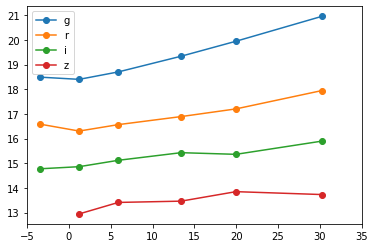

In [10]:
plt.plot(g_time, g_mag, label='g', marker='o')
plt.plot(r_time, r_mag-2, label = 'r', marker='o')
plt.plot(i_time, i_mag-4,label = 'i', marker='o')
plt.plot(z_time, z_mag-6, label = 'z', marker='o')
plt.legend()
# plt.ylim(19,10)
plt.xlim(-5, 35)
plt.show() 

In [11]:
# cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
# z = pyro.sample("z", dist.Uniform(0.015, 0.08)).numpy()
# mu_s = cosmo.distmod(z).value

z = 0.018
# mu_s = 31.

z_helio = 0.06741 ## for AT2016aj
EBV_MW = 0.0414 ## for AT2016aj

z = z_helio

ZPT = 27.5
M0 = -19.5
gamma = np.log(10) / 2.5

EBV_MW = 0.1
Av_obs = EBV_MW * 3.1

In [12]:
hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

Things we can pre-calculate
---



In [13]:
def get_lambda_int_for_band(band_wavelengths, z = z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(np.min(source_wavelengths), np.max(source_wavelengths), 150)

In [14]:
# times_to_interpolate = np.linspace(-10, 40)
times_to_interpolate = i_time.values
wavelengths_to_interpolate = get_lambda_int_for_band(i_wavelengths)

In [15]:
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))

In [16]:
xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
xis_matrix.shape

(150, 6)

In [17]:
## interpolate Hsiao coefficient at desired time and wavelength points
S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
for i, wavelength in enumerate(wavelengths_to_interpolate):
  for j, time in enumerate(times_to_interpolate):
    S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

In [18]:
throughput_interpolator = interp1d(i_wavelengths, i_norm_throughput)
b = throughput_interpolator(wavelengths_to_interpolate * (1 + z))

xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)
h.shape

(150,)

Now let's actually make the model
---

In [19]:
eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)

In [20]:
def get_flux_from_params(epsilon_interior, theta, mu_s, dMs, Av, W0 = W0, W1 = W1, xis_matrix = xis_matrix, S0 = S0, h = h, Jl = Jl, Jt = Jt):

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.numpy().reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  JlWJt = np.matmul(Jl, np.matmul(W, Jt.T))

  Stilde = S0 * np.exp(-gamma * (JlWJt + Av.numpy() * xis_matrix))

  f = 10**(0.4 * (ZPT - mu_s.numpy() - M0 - dMs.numpy())) * np.matmul(h,Stilde)

  return f

In [21]:
tauA

0.252

In [22]:
pyro.sample("Av", dist.Exponential(tauA))

tensor(0.1271)

In [23]:
# def model_vi():
#   epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))
#   theta = pyro.sample("theta", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
#   mu_s = pyro.sample("mu_s", dist.Normal(34.5, 1.)) ## fix this later


#   # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
#   dMs = torch.tensor(0.)
#   # Av = pyro.sample("Av", dist.Exponential(tauA))
#   Av = pyro.sample("Av", dist.Normal(0.27, 1.))

#   epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
#   epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

#   W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

#   JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

#   Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

#   f = 10**(0.4 * ZPT - mu_s - M0 - dMs) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))

#   with pyro.plate("observations", len(i_flux.values)):
#     pyro.sample("flux", dist.Normal(f, 200. * torch.ones(6)).independent(1), obs = torch.as_tensor(i_flux.values))

In [24]:
Av_obs

0.31000000000000005

In [25]:
# times_to_interpolate = times

wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}
times_dict = {'g':g_time.values, 'r':r_time.values, 'i':i_time.values, 'z':z_time.values}

bands = ['g', 'r', 'i', 'z']

band_Jl = {}
band_xis_matrix = {}
band_S0 = {}
band_h = {}
band_Jt = {}

for band in bands:
  band_wavelengths = wavelengths_dict[band]
  band_norm_throughput = norm_throughput_dict[band]

  times_to_interpolate = times_dict[band]

  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
  band_Jt[band] = Jt

  wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
  
  Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
  band_Jl[band] = Jl
  xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
  xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
  band_xis_matrix[band] = xis_matrix

  S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
  for i, wavelength in enumerate(wavelengths_to_interpolate):
    for j, time_point in enumerate(times_to_interpolate):
      S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

  band_S0[band] = S0

  throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
  b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

  xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
  dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
  h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

  band_h[band] = h

#   band_flux = get_flux_from_params(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), 
#                               torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av),
#                               xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
  
#   all_band_fluxes.append(band_flux)

# all_band_fluxes = np.array(all_band_fluxes)

In [38]:
def model_vi(obs):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.float), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
  mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_helio).value, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  # generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)
  
  if obs is not None:
    for i in range(len(bands)):
      # with pyro.plate("observations"):
        # print(len(generated_fluxes[i]))
        for j in range(len(generated_fluxes[i])):
            pyro.sample("flux" + str(i) + str(j), dist.Normal(generated_fluxes[i][j], 0.02 * generated_fluxes[i][j]), obs = obs[0][i][j])
          # print(obs[0][i][j])
        # print(generated_fluxes[i])

In [39]:
observed_fluxes = [(torch.as_tensor(g_flux.values), torch.as_tensor(r_flux.values), torch.as_tensor(i_flux.values), torch.as_tensor(z_flux.values))]

In [40]:
observed_fluxes[0][0]

tensor([4005.5530, 4352.0480, 3297.3020, 1835.4070, 1048.1200,  412.0150],
       dtype=torch.float64)

In [41]:
other_tensor = torch.as_tensor(np.array([[52404.7879, 58130.4852, 46895.5337, 29594.8725, 17534.0982, 11053.1069],
        [48598.4592, 57606.4501, 51917.4832, 38853.5554, 30378.8843, 24328.2872],
        [40029.6385, 34592.7530, 29652.9017, 23438.5865, 22959.2071, 21189.7540],
        [30952.7222, 34969.4993, 35130.8207, 31905.8129, 28952.3929, 26269.5857]]))

In [42]:
len(other_tensor[0])

6

In [43]:
model_vi(obs = observed_fluxes)

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at flux00
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at flux01
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at flux02
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at flux03
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at flux04
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at flux05
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarnin

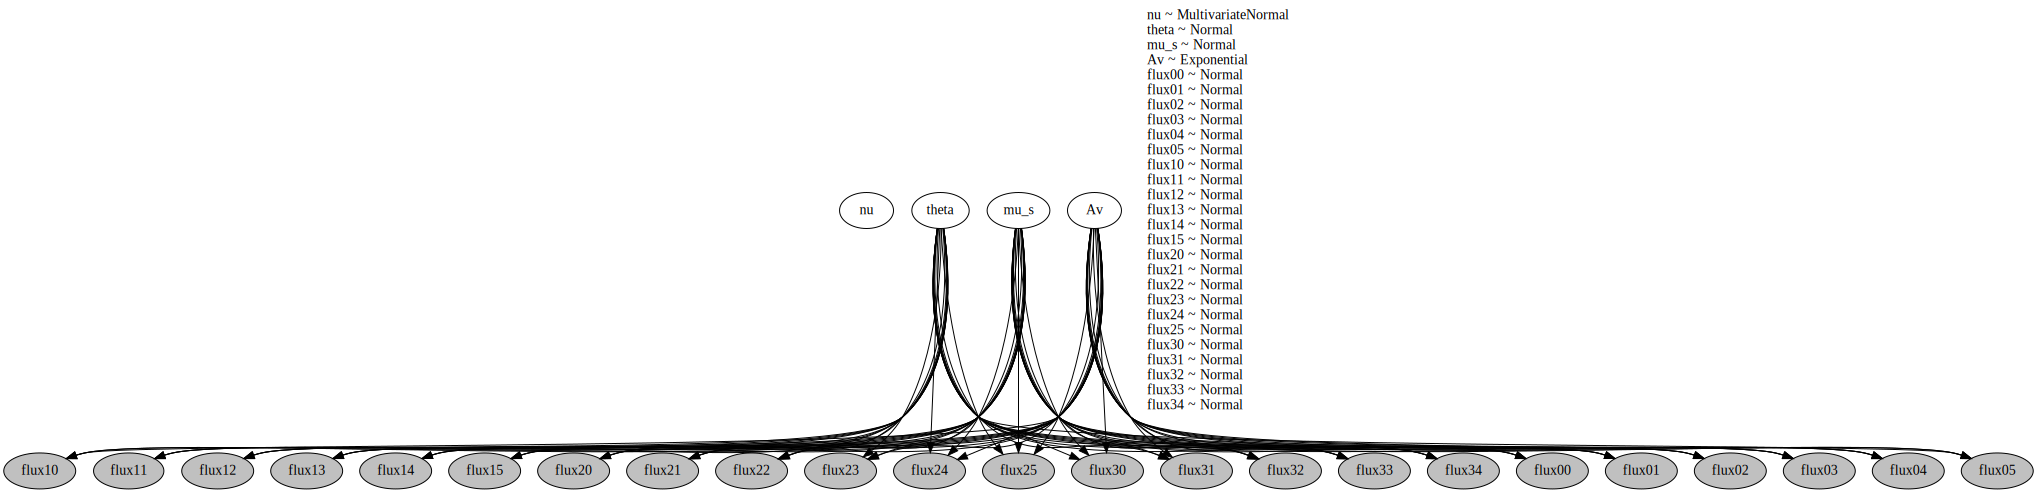

In [44]:
pyro.render_model(model_vi, model_args = (observed_fluxes,), render_distributions=True, render_params = True)

In [45]:
autoguide_vi = pyro.infer.autoguide.AutoMultivariateNormal(model_vi, init_loc_fn = pyro.infer.autoguide.initialization.init_to_median(), init_scale = 1.)

In [46]:
pyro.get_param_store().clear()
adam = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)}, {"clip_norm": 10.0})
# adam = pyro.optim.SGD({"lr": 0.1})


svi = SVI(model_vi, autoguide_vi, adam, loss=Trace_ELBO().differentiable_loss)
# svi = SVI(model_vi, custom_guide, adam, loss=Trace_ELBO().differentiable_loss)

for i in range(10):
  svi.step(observed_fluxes)

In [47]:
def train(model, guide, lr=0.01, n_steps=5000, verbose = True):
    pyro.get_param_store().clear()
    adam_params = {"lr": lr, "betas": (0.95, 0.999)}
    # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
    adam = pyro.optim.ClippedAdam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    losses = []
    losses_every_500 = []

    for step in range(n_steps):
        loss = svi.step(observed_fluxes)
        losses.append(loss)
        if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
            losses_every_500.append(loss)
            ## if it hasn't decreased in 3 steps, end fitting
            # if step > 2000:
            #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
            #   break
    return losses

In [48]:
start_time = measure_time.time()
losses = train(model_vi, autoguide_vi, lr = 0.01, n_steps = 20000)
end_time = measure_time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 28737.6594
[iter 500]  loss: 5734.2545
[iter 1000]  loss: 2442.8503
[iter 1500]  loss: 823.0514
[iter 2000]  loss: 540.1344
[iter 2500]  loss: 390.5884
[iter 3000]  loss: 316.9786
[iter 3500]  loss: 289.2928
[iter 4000]  loss: 280.7161
[iter 4500]  loss: 272.9736
[iter 5000]  loss: 271.7381
[iter 5500]  loss: 273.9233
[iter 6000]  loss: 267.8954
[iter 6500]  loss: 268.3938
[iter 7000]  loss: 293.9357
[iter 7500]  loss: 259.5553
[iter 8000]  loss: 267.4891
[iter 8500]  loss: 270.8316
[iter 9000]  loss: 268.0387
[iter 9500]  loss: 283.0055
[iter 10000]  loss: 289.5327
[iter 10500]  loss: 286.2216
[iter 11000]  loss: 295.1650
[iter 11500]  loss: 263.5624
[iter 12000]  loss: 268.7356
[iter 12500]  loss: 271.6931
[iter 13000]  loss: 284.8367
[iter 13500]  loss: 267.8728
[iter 14000]  loss: 268.1888
[iter 14500]  loss: 269.0305
[iter 15000]  loss: 269.7176
[iter 15500]  loss: 268.6662
[iter 16000]  loss: 289.9424
[iter 16500]  loss: 267.9455
[iter 17000]  loss: 263.7395
[iter

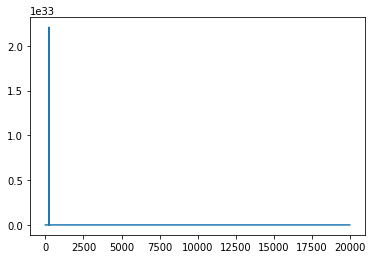

In [49]:
plt.plot(losses)

In [50]:
autoguide_vi.median()['theta']

tensor(0.4656)

In [51]:
autoguide_vi.median()['Av']

tensor(0.1549)

In [52]:
autoguide_vi.median()['mu_s']

tensor(37.1774)

In [53]:
autoguide_vi.median()['nu']

tensor([ 0.7959, -0.2100,  0.6792,  0.0919, -1.6730, -0.8837,  0.5014, -0.5140,
        -0.4595, -0.0413,  0.4972, -0.2227,  0.9612,  0.6361,  0.0829,  0.5586,
         0.0370, -0.3188,  0.1954,  0.6437, -0.5491,  1.4340,  0.3324, -2.6418,
        -0.3449, -0.7719, -1.0019, -1.7496, -1.7225, -0.9140, -0.9251,  0.9364,
         0.9174, -0.5798,  0.3091, -0.1493,  0.2122,  0.7007,  1.0706,  2.5785,
         0.0764, -2.0274,  0.1272,  0.0357,  0.1230, -0.0313,  0.0130, -0.1472,
        -0.1647, -0.2076, -0.2128,  0.0589, -0.0565, -0.0506])

In [ ]:
autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi)
start_time = measure_time.time()
losses = train(model_vi, autoguide_laplace, n_steps = 10000)
end_time = measure_time.time()
print("Time:", end_time - start_time, "seconds")

In [ ]:
new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes)
losses = train(model_vi, new_laplace_approx_guide, n_steps = 10000)

In [ ]:
posterior_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = 100)(None,)
posterior_samples['Av']

In [ ]:
def calculate_all_fluxes_from_params(nu, theta, mu_s, dMs, Av):
  times_to_interpolate = np.linspace(-10, 40)
  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

  epsilon_interior = np.matmul(L_sigma_epsilon, nu.numpy().T)

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  generated_fluxes_from_params = []

  for band in bands:
    band_wavelengths = wavelengths_dict[band]
    band_norm_throughput = norm_throughput_dict[band]

    Jl = band_Jl[band]
    # xis_matrix = band_xis_matrix[band]
    # h = band_h[band]

    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
    
    # Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T

    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

    band_flux = get_flux_from_params(torch.as_tensor(epsilon_interior), torch.as_tensor(theta), 
                                torch.as_tensor(mu_s), torch.as_tensor(dMs), torch.as_tensor(Av),
                                xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
    
    generated_fluxes_from_params.append(band_flux)
  
  return np.array(generated_fluxes_from_params)

In [ ]:
posterior_smooth_curves = []
for nu, theta, mu_s, Av in zip(posterior_samples['nu'][:,0,0], posterior_samples['theta'][:,0,0], posterior_samples['mu_s'][:,0,0], posterior_samples['Av'][:,0,0]):
  # print(nu, theta, mu_s, Av)
  posterior_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [ ]:
posterior_smooth_curves = np.array(posterior_smooth_curves)
median_posterior_fit = np.median(posterior_smooth_curves, axis = 0)
upper_posterior_fit = np.percentile(posterior_smooth_curves, 50 + 34.1, axis = 0)
lower_posterior_fit = np.percentile(posterior_smooth_curves, 50 - 34.1, axis = 0)

In [ ]:
colors  = ['g', 'r', 'c', 'k']
# offset = np.array([0, 1000,2000,3000]) * 30
offset = np.zeros(4)
for i, band_flux in enumerate(median_posterior_fit):
    plt.plot(np.linspace(-10, 40), band_flux + offset[i], color = colors[i])
    plt.fill_between(np.linspace(-10, 40), upper_posterior_fit[i]+ offset[i], lower_posterior_fit[i]+ offset[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(observed_fluxes.numpy()):
  plt.plot(times_to_interpolate, band_flux + offset[i], 'o',color = colors[i], label = bands[i])
plt.legend()
plt.title("Posterior samples from VI")

In [54]:
num_corner_samples = 1000
vi_corner_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = num_corner_samples)(None,)

In [ ]:
vi_trained_laplace_samples = Predictive(model_vi, guide = new_laplace_approx_guide, num_samples = num_corner_samples)(None,)

In [ ]:
laplace_samples = Predictive(model_vi, guide = autoguide_laplace.laplace_approximation(observed_fluxes), num_samples = num_corner_samples)(None,)

In [55]:
other_fit = np.load("AT2016aj_chains_210610_135216.npy", allow_pickle = True).item()

In [56]:
other_fit.keys()

odict_keys(['lp__', 'mu', 'AV', 'theta', 'delM', 'epsilon'])

In [57]:
len(other_fit['mu'])

1000

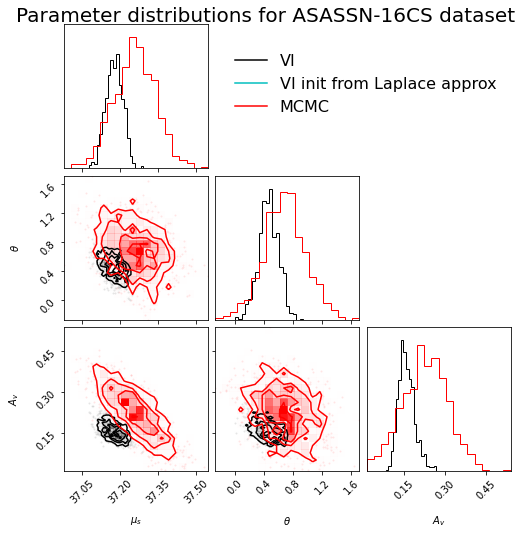

In [58]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'].numpy(),vi_corner_samples['theta'].numpy(), 
                                  vi_corner_samples['Av'].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"])
# corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'][:,0,0].numpy(),vi_trained_laplace_samples['theta'][:,0,0].numpy(), 
#                                   vi_trained_laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'c')
# corner.corner(np.vstack((laplace_samples['mu_s'][:,0,0].numpy(),laplace_samples['theta'][:,0,0].numpy(), 
#                                   laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'b')
corner.corner(np.vstack((other_fit['mu'] + other_fit['delM'],other_fit['theta'], other_fit['AV'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')
colors = ['k','c', 'r']

labels = ['VI', 'VI init from Laplace approx', 'MCMC']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.suptitle("Parameter distributions for ASASSN-16CS dataset", fontsize = 20)
plt.show()

In [59]:
def model_mcmc(obs):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.double), nu.double())
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
  mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_helio).value, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  # generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  for i in range(len(bands)):
    # with pyro.plate("observations"):
      # print(len(generated_fluxes[i]))
      for j in range(len(generated_fluxes[i])):
          pyro.sample("flux" + str(i) + str(j), dist.Normal(generated_fluxes[i][j], 0.02 * generated_fluxes[i][j]), obs = obs[0][i][j])
          # print(obs[0][i][j])
        # print(generated_fluxes[i])

In [61]:
num_chains = 1
nuts_kernel = pyro.infer.NUTS(model_mcmc, adapt_step_size=True)

mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=600, warmup_steps=250, num_chains = num_chains)

start_time = measure_time.time()
mcmc.run(observed_fluxes)
end_time = measure_time.time()
print("Total:", end_time - start_time, "seconds")

Sample: 100%|██████████| 850/850 [1:22:04,  5.79s/it, step size=2.88e-02, acc. prob=0.905]

Total: 4925.01154088974 seconds


In [62]:
mcmc_corner_samples = mcmc.get_samples(num_samples = num_corner_samples)

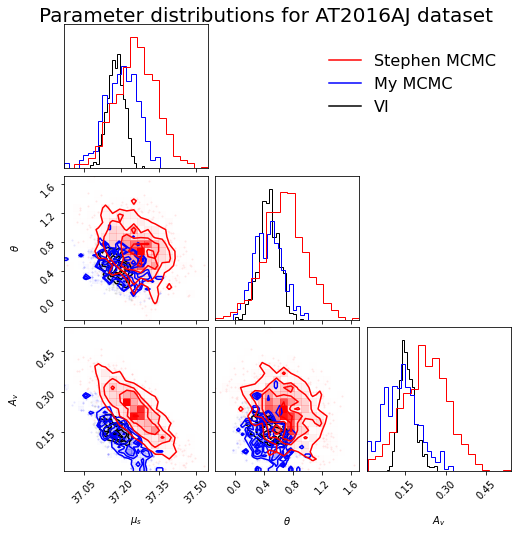

In [66]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'].numpy(),vi_corner_samples['theta'].numpy(), 
                                  vi_corner_samples['Av'].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], color = 'k')
# corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'][:,0,0].numpy(),vi_trained_laplace_samples['theta'][:,0,0].numpy(), 
#                                   vi_trained_laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'c')
corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], color ='b',fig = figure,)
# corner.corner(np.vstack((laplace_samples['mu_s'][:,0,0].numpy(),laplace_samples['theta'][:,0,0].numpy(), 
#                                   laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'b')
corner.corner(np.vstack((other_fit['mu'] + other_fit['delM'],other_fit['theta'], other_fit['AV'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')
# colors = ['k','c', 'r']

# labels = ['VI', 'VI init from Laplace approx', 'MCMC']
colors = ['r', 'b', 'k']
labels = ['Stephen MCMC', 'My MCMC', 'VI']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.suptitle("Parameter distributions for AT2016AJ dataset", fontsize = 20)
plt.show()

In [71]:
many_samples = mcmc.get_samples(num_samples = 10000)
np.savetxt("mcmc_at2016aj_samples.txt",[many_samples['mu_s'].numpy(),many_samples['theta'].numpy(),many_samples['Av'].numpy()])